In [1394]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from utils import get_data, get_probabilities, estimate_q_Z_given_A, get_probabilities_one_hot
from sklearn.decomposition import NMF  # Placeholder for volmin factorization
from volmin_nmf import *
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [1395]:
p_source = 0.8
p_target = 0.2
total = 10000
factorisation_atol = 1e-1

# Step 2 parameters
specific_a_index = 0  # First value of A

# "sklearn" for sklearn's NMF
# "volmin_1" for volmin NMF, adapted from https://github.com/kharchenkolab/vrnmf
# "volmin_2" for volmin NMF, adapted from https://github.com/bm424/mvcnmf/blob/master/mvcnmf.py
nmf_method = "volmin_2" 
# parameters for volmin NMF
w_vol = 0.1
delta = 1e-8
n_iter = 100000
err_cut = 1e-8

In [1396]:
# 2x2 matrix
theta_w_epsilon = torch.tensor([
    [-1, 1],
    [1, -1]
])

# 2x2 matrix
theta_z_epsilon = torch.tensor([
    [1, -1],
    [-1, 1]
])

theta_a_z_epsilon = torch.tensor([
    [1, -1],
    [-1, 1],
    [1, -1]
]) #negate when epsilon is 1

# 1x5 matrix concatenating 1 hot of w and a. Negate when epsilon is 1. a is 3D and w is 2D
theta_y_a_w_epsilon = torch.tensor([
    #[3, 2, -1, -1, 1]
    #[3, 1, -2, -1, 1]
    [30, 5, -20, -10, 10] # larger values seem to push the sigmoid to the extremes
]) 


In [1397]:
def get_tuple_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p=0.2):
    epsilon = torch.bernoulli(torch.tensor([p])).long() # (1,)
    epsilon_one_hot = torch.nn.functional.one_hot(torch.tensor(epsilon), num_classes=2).squeeze() # (1,2)

    z = np.sign(epsilon_one_hot@theta_z_epsilon) # discrete so categorical depending on epsilon (paper has Normal as cont)
    w = np.sign(epsilon_one_hot@theta_w_epsilon) # discrete so categorical depending on epsilon (paper has Normal as cont)

    # w given z and a should be perfect

    a_logits = epsilon * theta_a_z_epsilon @ z + (epsilon-1) * theta_a_z_epsilon @ z #epsilon is 0 or 1, theta_a_z_epsilon is 3x2, z is [2]. So result is 3x1
    a = torch.bernoulli(torch.sigmoid(a_logits)).float().squeeze() # a is size 3

    # concatenate w and a
    # then similar but use different matrix and w,a instead of z
    wa = torch.cat((w, a), dim=0) # [5]

    y_logits = epsilon * theta_y_a_w_epsilon @ wa.long() + (epsilon-1) * theta_y_a_w_epsilon @ wa.long() # y is a function of a, w and epsilon from the graph
    print(torch.sigmoid(y_logits))
    y = torch.bernoulli(torch.sigmoid(y_logits).squeeze()).float()

    return epsilon,z,w,a,y

def get_dataset_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p, total):
    U,Z,W,X,Y = [],[],[],[],[]
    for _ in range(total):
        u,z,w,x,y = get_tuple_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p)
        U.append(u)
        Z.append(z)
        W.append(w)
        X.append(x)
        Y.append(y)

    return U,Z,W,X,Y

def get_data_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_source, p_target, total):
    
    # Source distribution data
    U_source, Z_source, W_source, X_source, Y_source = get_dataset_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_source, total)
    
    # Target distribution data
    U_target, Z_target, W_target, X_target, Y_target = get_dataset_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_target, total)
    
    return (Z_source, U_source, W_source, X_source, Y_source), \
           (Z_target, U_target, W_target, X_target, Y_target)

In [1398]:
source_data, target_data = get_data_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_source, p_target, total)
Z_source, epsilon_source, W_source, A_source, Y_source = source_data
Z_target, epsilon_target, W_target, A_target, Y_target = target_data

/var/folders/tf/g242212x4tsbkxq6k9xkfvn80000gn/T/ipykernel_33707/734909782.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  epsilon_one_hot = torch.nn.functional.one_hot(torch.tensor(epsilon), num_classes=2).squeeze() # (1,2)


tensor([1.0000])
tensor([1.0000])
tensor([1.])
tensor([1.0000])
tensor([1.])
tensor([0.9933])
tensor([1.0000])
tensor([1.])
tensor([1.0000])
tensor([1.0000])
tensor([1.])
tensor([0.0067])
tensor([1.])
tensor([1.])
tensor([1.0000])
tensor([1.0000])
tensor([1.0000])
tensor([1.])
tensor([1.])
tensor([1.0000])
tensor([1.0000])
tensor([1.0000])
tensor([1.0000])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.0000])
tensor([1.0000])
tensor([1.0000])
tensor([1.])
tensor([1.0000])
tensor([1.0000])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.0000])
tensor([1.0000])
tensor([1.0000])
tensor([1.0000])
tensor([1.0000])
tensor([1.0000])
tensor([1.0000])
tensor([1.0000])
tensor([0.9933])
tensor([0.0067])
tensor([1.])
tensor([1.0000])
tensor([1.])
tensor([0.0067])
tensor([1.0000])
tensor([1.])
tensor([0.0067])
tensor([1.])
tensor([1.])
tensor([1.0000])
tensor([1.0000])
tensor([1.])
tensor([1.])
tensor([1.0000])
tensor([1.0000])
tensor([1.0000])
tensor([1.0000])
tensor([

KeyboardInterrupt: 

In [ ]:
sum(Y_source) # Y_source is almost all 1 for some reason

tensor(9234.)

In [ ]:
print("Y_source.shape", len(Y_source))
print("W_source.shape", len(W_source))
print("A_source.shape", len(A_source))
print("Z_source.shape", len(Z_source))

print("Y_source", Y_source)
print("W_source", W_source)
print("A_source", A_source)
print("Z_source", Z_source)

Y_source.shape 10000
W_source.shape 10000
A_source.shape 10000
Z_source.shape 10000
Y_source [tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor

In [ ]:
def plot_histograms(data, label):
    Z, epsilon, W, A, Y = data

    # Convert tensors to numpy arrays
    Z_np = np.array(Z)
    epsilon_np = np.array(epsilon)
    W_np = np.array(W)
    A_np = np.array(A)
    Y_np = np.array(Y)

    # Flatten the arrays for histogram plotting
    Z_flat = Z_np.flatten()
    epsilon_flat = epsilon_np.flatten()
    W_flat = W_np.flatten()
    A_flat = A_np.flatten()
    Y_flat = Y_np.flatten()

    # Plot histograms
    plt.figure(figsize=(10, 5))

    plt.subplot(2, 3, 1)
    plt.hist(Z_flat, bins=20, color='blue', alpha=0.7)
    plt.title(f'Histogram of Z_{label}')

    plt.subplot(2, 3, 2)
    plt.hist(epsilon_flat, bins=20, color='green', alpha=0.7)
    plt.title(f'Histogram of epsilon_{label}')

    plt.subplot(2, 3, 3)
    plt.hist(W_flat, bins=20, color='red', alpha=0.7)
    plt.title(f'Histogram of W_{label}')

    plt.subplot(2, 3, 4)
    plt.hist(A_flat, bins=20, color='purple', alpha=0.7)
    plt.title(f'Histogram of A_{label}')

    plt.subplot(2, 3, 5)
    plt.hist(Y_flat, bins=20, color='orange', alpha=0.7)
    plt.title(f'Histogram of Y_{label}')

    plt.tight_layout()
    plt.show()


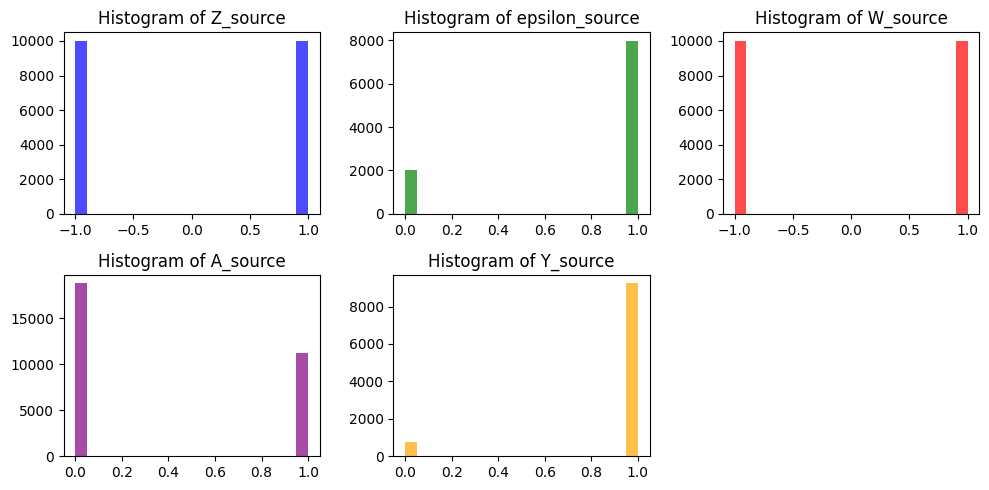

In [ ]:
plot_histograms(source_data, "source")

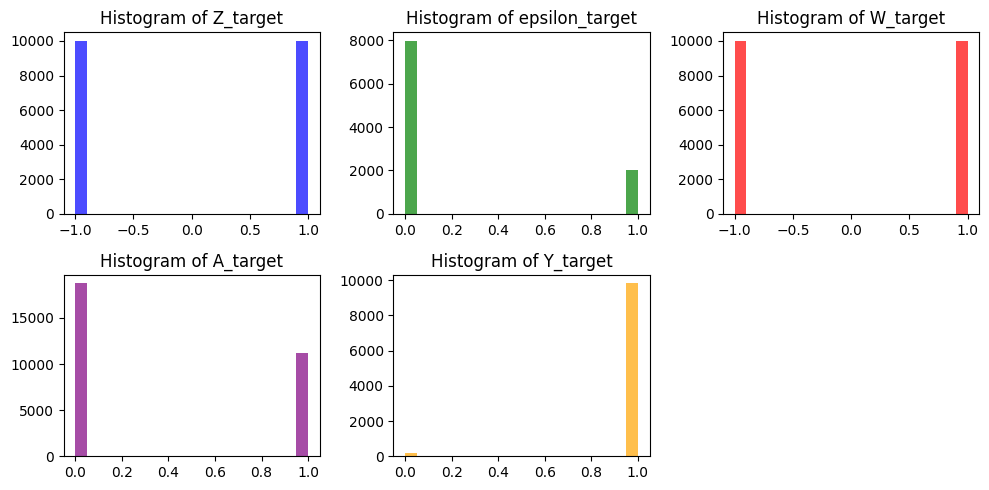

In [ ]:
plot_histograms(target_data, "target")

In [ ]:
# def flatten_and_convert(tensor_list):
#     # Concatenate list of tensors and convert to NumPy array
#     concatenated_tensor = torch.cat(tensor_list, dim=0)
#     numpy_array = concatenated_tensor.numpy()
#     return numpy_array

# def plot_distributions(Z_source, W_source, A_source, Y_source):
#     combinations = list(itertools.product(range(4), range(4)))
    
#     plt.figure(figsize=(20, 20))
    
#     # Convert one-hot encoded tensors to indices directly
#     Z_indices = np.argmax(flatten_and_convert(Z_source), axis=1).flatten()
#     A_indices = np.argmax(flatten_and_convert(A_source), axis=1).flatten()
#     Y_indices = flatten_and_convert(Y_source).flatten()  # Y_source is already binary, just flatten it
#     W_indices = np.argmax(flatten_and_convert(W_source), axis=1).flatten()

#     print(Y_indices.shape)
    
#     # Print the first few indices for debugging
#     print("Z_indices (first 10):", Z_indices[:10])
#     print("A_indices (first 10):", A_indices[:10])
#     print("Y_indices (first 10):", Y_indices[:10])
#     print("W_indices (first 10):", W_indices[:10])
    
#     for i, (z_val, a_val) in enumerate(combinations):
#         indices = (Z_indices == z_val) & (A_indices == a_val)
        
#         Y_subsample = Y_indices[indices]
#         W_subsample = W_indices[indices]
        
#         plt.subplot(8, 4, 2 * i + 1)
#         plt.hist(Y_subsample, bins=np.arange(3) - 0.5, color='orange', alpha=0.7)
#         plt.title(f'Y | Z={z_val}, A={a_val}')
#         plt.xticks([0, 1])
        
#         plt.subplot(8, 4, 2 * i + 2)
#         plt.hist(W_subsample, bins=np.arange(5) - 0.5, color='blue', alpha=0.7)
#         plt.title(f'W | Z={z_val}, A={a_val}')
#         plt.xticks([0, 1, 2, 3])
    
#     plt.tight_layout()
#     plt.show()

# plot_distributions(Z_source, W_source, A_source, Y_source)

In [ ]:
num_classes_Y = 2 
num_classes_W = 2
num_features_Z = 2
num_features_A = 3

sum_epsilon = np.sum(epsilon_source)
print("Sum of epsilon_source:", sum_epsilon.item())

sum_Y = np.sum(Y_source)
print("Sum of Y_source:", sum_Y.item())

Sum of epsilon_source: 7974
Sum of Y_source: 9234.0


In [ ]:
# =============================================================================
# Step 1: Estimate p(Y|Z,a) and p(W|Z,a)
# =============================================================================

# Train model to estimate p(Y|Z,a)
# By stacking with A, we condition on A by including all values of A in the input
ZA_source = np.hstack((Z_source, A_source)) 
# if step1_debug:
#     print("ZA_source.shape", ZA_source.shape)  # Debug print statement
#     print("ZA_source", ZA_source)  # Debug print statement

############### LOGISTIC REGRESSION VERSION ###############

#model_Y = LogisticRegression(input_dim=ZA_source.shape[1], num_classes=2)
#model_Y.train(torch.tensor(ZA_source, dtype=torch.float32), torch.tensor(Y_source, dtype=torch.float32))

# model_Y = LogisticRegressionGD(input_dim=ZA_source.shape[1], num_classes=Y_source.shape[1])
# model_Y.train_model(torch.tensor(ZA_source, dtype=torch.float32), torch.tensor(Y_source, dtype=torch.float32), learning_rate=0.01, epochs=100, verbose=True)
# p_Y_given_ZA = get_probabilities(model_Y, Z_source, A_source)

In [ ]:
# class SimpleNN(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(SimpleNN, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 32)
#         self.fc4 = nn.Linear(32, 16)
#         self.fc5 = nn.Linear(16, output_dim)
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = torch.relu(self.fc2(x))
#         x = self.dropout(x)
#         x = torch.relu(self.fc3(x))
#         x = self.dropout(x)
#         x = torch.relu(self.fc4(x))
#         x = self.dropout(x)
#         x = self.fc5(x)
#         return x

# def train_nn(model, X_data, Y_data, learning_rate=0.001, epochs=50, batch_size=32):
#     if not isinstance(X_data, torch.Tensor):
#         X_tensor = torch.tensor(X_data, dtype=torch.float32)
#     else:
#         X_tensor = X_data

#     if not isinstance(Y_data, torch.Tensor):
#         Y_tensor = torch.tensor(Y_data, dtype=torch.long)
#     else:
#         Y_tensor = Y_data.long()

#     # Ensure the first dimensions match
#     assert X_tensor.size(0) == Y_tensor.size(0), f"Size mismatch between X and Y: {X_tensor.size(0)} != {Y_tensor.size(0)}"

#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     dataset = TensorDataset(X_tensor, Y_tensor)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
#     for epoch in range(epochs):
#         for batch_X, batch_Y in dataloader:
#             optimizer.zero_grad()
#             outputs = model(batch_X)
#             loss = criterion(outputs, batch_Y)
#             loss.backward()
#             optimizer.step()
#         if (epoch + 1) % 10 == 0:
#             print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# def eval_nn(model, X_data, Y_data):
#     if not isinstance(X_data, torch.Tensor):
#         X_tensor = torch.tensor(X_data, dtype=torch.float32)
#     else:
#         X_tensor = X_data

#     if not isinstance(Y_data, torch.Tensor):
#         Y_tensor = torch.tensor(Y_data, dtype=torch.long)
#     else:
#         Y_tensor = Y_data.long()
    
#     with torch.no_grad():
#         outputs = model(X_tensor)
#         _, predicted = torch.max(outputs, 1)
#         correct = (predicted == Y_tensor).sum().item()
#         accuracy = correct / Y_tensor.size(0)
#     return accuracy


In [ ]:
# Y_source = torch.stack(Y_source).long()

In [ ]:
# Y_source

In [ ]:
# # Define and train the neural network
# input_dim = ZA_source.shape[1]
# model_Y = SimpleNN(input_dim, num_classes_Y)
# train_nn(model_Y, ZA_source, Y_source, learning_rate=0.001, epochs=100, batch_size=32)


In [ ]:
# # Evaluate the model
# accuracy_nn = eval_nn(model_Y, ZA_source, torch.tensor(Y_source.flatten(), dtype=torch.long))
# print(f'Accuracy of neural network model on training set: {accuracy_nn:.4f}')

In [ ]:
############### SKLEARN VERSION ###############

# print("Y_source flatten", Y_source.flatten())
ZA_source

##### LOGISTIC REGRESSION #####
model_Y = SklearnLogisticRegression(max_iter=1000)
model_Y.fit(ZA_source, Y_source)

##### GRAIDENT BOOSTING #####
# model_Y = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=0)
# model_Y.fit(ZA_source, Y_source)

##### RANDOM FOREST #####
# model_Y = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
# model_Y.fit(ZA_source, Y_source)

##### NEURAL NETWORK #####
# model_Y = MLPClassifier(hidden_layer_sizes=(8, 4), max_iter=1000)
# model_Y.fit(ZA_source, Y_source)


print(ZA_source)
print(Y_source)
Y_train_pred = model_Y.predict(ZA_source)
print("Y_train_pred",Y_train_pred)

Y_train_true = Y_source
accuracy_Y_train = np.mean(Y_train_pred == Y_source)
print(f"Accuracy of model_Y on training set: {accuracy_Y_train:.4f}")


[[-1.  1.  0.  1.  0.]
 [-1.  1.  0.  0.  1.]
 [-1.  1.  0.  1.  1.]
 ...
 [-1.  1.  0.  1.  0.]
 [-1.  1.  0.  1.  0.]
 [-1.  1.  0.  1.  0.]]
[tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), ten

In [ ]:
cm = confusion_matrix(Y_source, model_Y.predict(ZA_source))
print("Classification Report:")
print(classification_report(Y_source, model_Y.predict(ZA_source)))

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       766
         1.0       1.00      1.00      1.00      9234

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



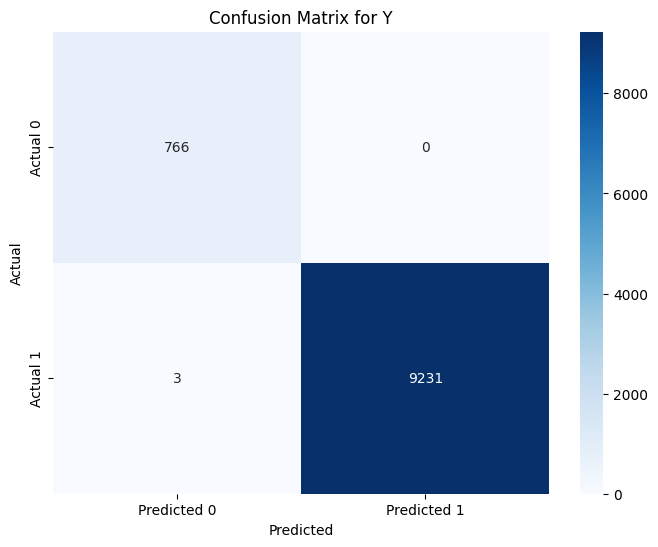

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Y')
plt.show()

In [ ]:
# def get_probabilities_one_hot_nn(model, Z, A):
#     """
#     Computes the softmax probabilities from the trained model.
    
#     Args:
#         model (model): Trained model.
#         Z (numpy.ndarray): Feature matrix Z.
#         A (numpy.ndarray): Feature matrix A.

#     Returns:
#         numpy.ndarray: Probability matrix reshaped to (|Z|, |A|, |Y|) or (|Z|, |A|, |W|).
#     """
#     num_Z = Z.shape[1]
#     num_A = A.shape[1]
#     num_classes = model.fc5.out_features #number of layers here

#     # Generate all possible one-hot vectors for Z
#     possible_Z = np.eye(num_Z)
#     possible_A = np.eye(num_A)
    
#     probabilities = []
    
#     for z in possible_Z:
#         for a in possible_A:
#             ZA = np.hstack((z.reshape(1, -1), a.reshape(1, -1)))
#             ZA_tensor = torch.tensor(ZA, dtype=torch.float32)
#             with torch.no_grad():
#                 probs = model(ZA_tensor)
#                 probs = torch.softmax(probs, dim=1).numpy()
#                 probabilities.append(probs[0])
    
#     probabilities = np.array(probabilities).reshape((num_Z, num_A, num_classes))
    
#     return probabilities

In [ ]:

# p_Y_given_ZA = get_probabilities_one_hot_nn(model_Y, Z_source, A_source)
# print("p_Y_given_ZA", p_Y_given_ZA)
# print("p_Y_given_ZA shape:", p_Y_given_ZA.shape)  # Debug print statement


In [ ]:

# # Verify the shape of p_Y_given_ZA
# assert p_Y_given_ZA.shape == (num_features_Z, num_features_A, num_classes_Y), f"p_Y_given_ZA shape mismatch: {p_Y_given_ZA.shape}"
# assert np.allclose(p_Y_given_ZA.sum(axis=2), 1.0), "p_Y_given_ZA rows do not sum to 1"
# print("Step 1: p_Y_given_ZA shape and sum are correct.")



In [ ]:
# W_source_indices = torch.argmax(torch.tensor(W_source), dim=1)
# print(W_source)
# print(W_source_indices)

In [ ]:
#convert to binary

def tensor_to_binary(tensor):
    return 1 if tensor[0] == 1 else 0

# Convert the list of tensors to a list of binary labels
binary_labels = [tensor_to_binary(t) for t in W_source]

# Convert to numpy array (optional)
binary_labels_array = np.array(binary_labels)

In [ ]:
############### LOGISTIC REGRESSION VERSION ###############
#Train model to estimate p(W|Z,a)
# model_W = LogisticRegressionGD(input_dim=ZA_source.shape[1], num_classes=W_source.shape[1])
# model_W.train_model(torch.tensor(ZA_source, dtype=torch.float32), torch.tensor(Y_source, dtype=torch.float32), learning_rate=0.01, epochs=100, verbose=True)

# p_W_given_ZA = get_probabilities_one_hot(model_W, Z_source, A_source)



############### SKLEARN VERSION ###############

# model_W = SklearnLogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
# model_W.fit(ZA_source, np.argmax(W_source, axis=1))
# W_train_pred = model_W.predict(ZA_source)
# W_train_true = np.argmax(W_source, axis=1)
# accuracy_W_train = np.mean(W_train_pred == W_train_true)
# print(f"Accuracy of model_W on training set: {accuracy_W_train:.4f}")
#p_W_given_ZA = model_W.predict_proba(ZA_source).reshape(num_features_Z, num_features_A, num_classes_W)

model_W= SklearnLogisticRegression(max_iter=1000)
model_W.fit(ZA_source, binary_labels_array)

# print(ZA_source)
# print(W_source)
W_train_pred = model_W.predict(ZA_source)
print("W_train_pred",W_train_pred)

W_train_true = W_source
accuracy_W_train = np.mean(W_train_pred == binary_labels_array)
print(f"Accuracy of model_W on training set: {accuracy_W_train:.4f}")



############### NEURAL NETWORK VERSION ###############

# Define and train the neural network
# input_dim = ZA_source.shape[1]
# model_W = SimpleNN(input_dim, num_classes_W)
# train_nn(model_W, torch.tensor(ZA_source, dtype=torch.float32), W_source_indices, learning_rate=0.001, epochs=500, batch_size=16)

# # Evaluate the model
# accuracy_nn = eval_nn(model_W, torch.tensor(ZA_source, dtype=torch.float32), W_source_indices)
# print(f'Accuracy of neural network model on training set: {accuracy_nn:.4f}')


W_train_pred [1 1 1 ... 1 1 1]
Accuracy of model_W on training set: 1.0000


In [ ]:
cm_w = confusion_matrix(binary_labels_array, model_W.predict(ZA_source))
print("Classification Report for W:")
print(classification_report(binary_labels_array, model_W.predict(ZA_source)))

Classification Report for W:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2026
           1       1.00      1.00      1.00      7974

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



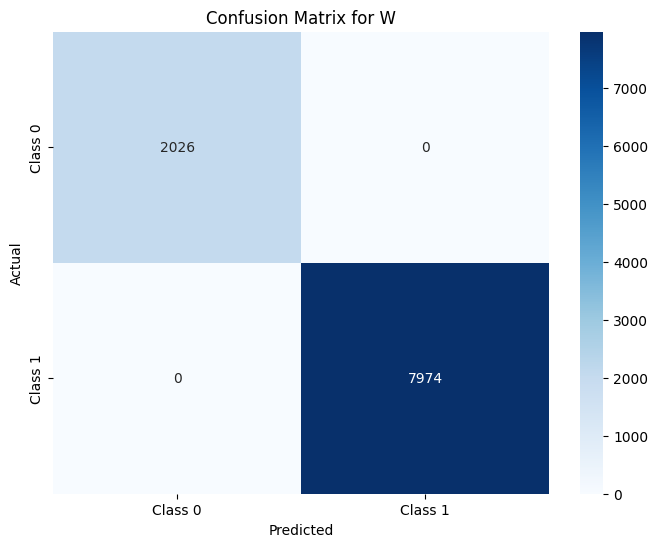

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_w, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for W')
plt.show()

In [ ]:
# p_W_given_ZA = get_probabilities(model_W, Z_source, A_source)

# if step1_debug:
#     print("p_W_given_ZA shape:", p_W_given_ZA.shape)  # Debug print statement
#     print("p_W_given_ZA", p_W_given_ZA)  # Debug print statement

# # Verify the shape of p_W_given_ZA
# assert p_W_given_ZA.shape == (num_features_Z, num_features_A, num_classes_W), f"p_W_given_ZA shape mismatch: {p_W_given_ZA.shape}"
# assert np.allclose(p_W_given_ZA.sum(axis=2), 1.0), "p_W_given_ZA rows do not sum to 1"
# if step1_debug:
#     print("Step 1: p_W_given_ZA shape and sum are correct.")

# print("STEP 1 DONE")

In [1403]:
np.array(binary_labels_array) # this is the true W
np.array(epsilon_source).squeeze() # this is true epsilon
count_W_0_eps_0 = np.sum((np.array(binary_labels_array) == 0) & (np.array(epsilon_source).squeeze() == 0))
count_W_1_eps_0 = np.sum((np.array(binary_labels_array) == 1) & (np.array(epsilon_source).squeeze() == 0))
count_W_0_eps_1 = np.sum((np.array(binary_labels_array) == 0) & (np.array(epsilon_source).squeeze() == 1))
count_W_1_eps_1 = np.sum((np.array(binary_labels_array) == 1) & (np.array(epsilon_source).squeeze() == 1))
print("Count W=0, epsilon=0:", count_W_0_eps_0)
print("Count W=1, epsilon=0:", count_W_1_eps_0)
print("Count W=0, epsilon=1:", count_W_0_eps_1)
print("Count W=1, epsilon=1:", count_W_1_eps_1)

# Total counts for eps = 0 and eps = 1
total_eps_0 = np.sum(np.array(epsilon_source).squeeze() == 0)
total_eps_1 = np.sum(np.array(epsilon_source).squeeze() == 1)

# Calculate the probabilities
P_W_0_given_eps_0 = count_W_0_eps_0 / total_eps_0 if total_eps_0 > 0 else 0
P_W_1_given_eps_0 = count_W_1_eps_0 / total_eps_0 if total_eps_0 > 0 else 0
P_W_0_given_eps_1 = count_W_0_eps_1 / total_eps_1 if total_eps_1 > 0 else 0
P_W_1_given_eps_1 = count_W_1_eps_1 / total_eps_1 if total_eps_1 > 0 else 0
print("P(W=0 | epsilon=0):", P_W_0_given_eps_0)
print("P(W=1 | epsilon=0):", P_W_1_given_eps_0)
print("P(W=0 | epsilon=1):", P_W_0_given_eps_1)
print("P(W=1 | epsilon=1):", P_W_1_given_eps_1)


Count W=0, epsilon=0: 2026
Count W=1, epsilon=0: 0
Count W=0, epsilon=1: 0
Count W=1, epsilon=1: 7974
P(W=0 | epsilon=0): 1.0
P(W=1 | epsilon=0): 0.0
P(W=0 | epsilon=1): 0.0
P(W=1 | epsilon=1): 1.0


0.0

In [ ]:
Z_source

[tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([ 1, -1]),
 tensor([-1,  1]),
 tensor([ 1, -1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([ 1, -1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([ 1, -1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([ 1, -1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([ 1, -1]),
 tensor([-1,  1]),
 tensor([ 1, -1]),
 tensor([-1,

In [ ]:
A_source

[tensor([0., 1., 0.]),
 tensor([0., 0., 1.]),
 tensor([0., 1., 1.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([1., 1., 1.]),
 tensor([0., 1., 0.]),
 tensor([0., 0., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 1.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 1.]),
 tensor([0., 1., 1.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 1.]),
 tensor([0., 1., 0.]),
 tensor([1., 1., 0.]),
 tensor([0., 0., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 1.]),
 tensor([0., 1., 0.]),
 tensor([1., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([1., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 0., 0.]),
 tensor([1.

In [ ]:
def get_probabilities(model, Z_source, A_source):
    """
    Computes the sigmoid probabilities from the trained model.
    
    Args:
        model (MLPClassifier): Trained scikit-learn MLPClassifier.
        Z_source (list of torch.Tensor): List of tensors for feature matrix Z.
        A_source (list of torch.Tensor): List of tensors for feature matrix A.

    Returns:
        numpy.ndarray: Probability matrix reshaped to (|Z|, |A|, 2) for binary classification.
    """
    # Convert lists of tensors to numpy arrays
    Z = np.array([z.numpy() for z in Z_source])
    A = np.array([a.numpy() for a in A_source])
    
    num_Z = Z.shape[1]
    num_A = A.shape[1]

    # Generate all possible one-hot vectors for Z and A
    possible_Z = np.eye(num_Z)
    possible_A = np.eye(num_A)
    
    probabilities = []
    
    for z in possible_Z:
        for a in possible_A:
            ZA = np.hstack((z.reshape(1, -1), a.reshape(1, -1)))
            # Flatten ZA for the MLPClassifier
            ZA_flat = ZA.flatten().reshape(1, -1)
            prob = model.predict_proba(ZA_flat)[0]
            probabilities.append(prob)
    
    probabilities = np.array(probabilities).reshape((num_Z, num_A, 2))
    
    return probabilities

In [ ]:
p_Y_given_ZA = get_probabilities(model_Y, Z_source, A_source)
print(p_Y_given_ZA)
p_Y_given_ZA_matrix = p_Y_given_ZA[:, specific_a_index, :]
print(p_Y_given_ZA_matrix)

[[[1.08931644e-04 9.99891068e-01]
  [3.40183362e-06 9.99996598e-01]
  [1.23274724e-11 1.00000000e+00]]

 [[7.04504180e-03 9.92954958e-01]
  [2.21498607e-04 9.99778501e-01]
  [8.02841349e-10 9.99999999e-01]]]
[[1.08931644e-04 9.99891068e-01]
 [7.04504180e-03 9.92954958e-01]]


In [ ]:
p_W_given_ZA = get_probabilities(model_W, Z_source, A_source)
print(p_W_given_ZA)
p_W_given_ZA_matrix = p_W_given_ZA[:, specific_a_index, :]
print(p_W_given_ZA_matrix)

[[[0.96518515 0.03481485]
  [0.95881912 0.04118088]
  [0.96532833 0.03467167]]

 [[0.0146091  0.9853909 ]
  [0.01229803 0.98770197]
  [0.01467069 0.98532931]]]
[[0.96518515 0.03481485]
 [0.0146091  0.9853909 ]]


In [ ]:
print("Step 1 done")

Step 1 done


In [ ]:
stacked_matrix = np.vstack((p_Y_given_ZA_matrix, p_W_given_ZA_matrix)) # this should be a |Y| x |Z| matrix stacked on top of a |W| x |Z| matrix (for specific a)
stacked_matrix

array([[1.08931644e-04, 9.99891068e-01],
       [7.04504180e-03, 9.92954958e-01],
       [9.65185151e-01, 3.48148492e-02],
       [1.46090971e-02, 9.85390903e-01]])

In [ ]:
# Determine the number of components for epsilon
num_epsilon = 2 # min(W_source.shape[1], Z_source.shape[1]) # Remember we need this to be less than the min of |W| and |Z|. Consider changing this as a hyperparameter

In [ ]:
W, H = mvc_nmf(stacked_matrix.T, num_epsilon, w_vol, n_iter, err_cut) # Transpose the matrix to match the input format of the function

Converged with error difference 9.733326195027203e-07


In [ ]:
print("W shape:", W.shape)
print("H shape:", H.shape)
print("W:", W)
print("H:", H)

W shape: (4, 2)
H shape: (2, 2)
W: [[0.80536971 0.06984851]
 [0.80017231 0.07552989]
 [0.08219042 0.86062597]
 [0.79450438 0.08172563]]
H: [[0.         1.15758726]
 [1.04249012 0.        ]]


In [ ]:
p_Y_given_epsilon = W[:num_classes_Y, :] # |Y| x |\Epsilon| matrix for specific a, the first num_classes_Y rows #CHECK NUM_CLASSES_Y IS THE ONE
p_W_given_epsilon = W[num_classes_Y:, :] # |W| x |\Epsilon| matrix for specific a, the rest of the rows #CHECK NUM_CLASSES_Y IS THE ONE
p_epsilon_given_ZA = H # |\Epsilon| x |Z| matrix for specific a

In [ ]:
# Print shapes to debug
print("p_Y_given_epsilon shape:", p_Y_given_epsilon.shape)
print("p_W_given_epsilon shape:", p_W_given_epsilon.shape)
print("p_epsilon_given_ZA shape:", p_epsilon_given_ZA.shape)
print("ZA_source shape:", ZA_source.shape)
print("p_Y_given_epsilon:", p_Y_given_epsilon)
print("p_W_given_epsilon (should be comparable to vec1 and vec2):", p_W_given_epsilon)
#print("p_W_given_epsilon marginalised:", np.sum(p_W_given_epsilon, axis=1).reshape(-1, 1))
# Verify the shapes of the factorized matrices
assert p_Y_given_epsilon.shape == (num_classes_Y, num_epsilon), f"p_Y_given_epsilon shape mismatch: {p_Y_given_epsilon.shape}" #CHECK NUM_CLASSES_Y IS THE ONE
assert p_W_given_epsilon.shape == (num_classes_W, num_epsilon), f"p_W_given_epsilon shape mismatch: {p_W_given_epsilon.shape}" #CHECK NUM_CLASSES_W IS THE ONE
expected_shape = (num_epsilon, num_features_Z)  # Z_source[1] should be 4
print("expected_shape", expected_shape)
assert p_epsilon_given_ZA.shape == expected_shape, f"p_epsilon_given_ZA shape mismatch: {p_epsilon_given_ZA.shape}"
print("Step 2: Factorization shapes are correct.")

# Verify reconstruction
reconstructed_stacked_matrix = np.dot(W, H)
print("stacked_matrix:", stacked_matrix)
print("reconstructed_stacked_matrix:", reconstructed_stacked_matrix)
assert np.allclose(stacked_matrix, reconstructed_stacked_matrix, atol = factorisation_atol), "Reconstructed matrix is not close to the original"
print("Step 2: Reconstruction is correct.")

p_Y_given_epsilon shape: (2, 2)
p_W_given_epsilon shape: (2, 2)
p_epsilon_given_ZA shape: (2, 2)
ZA_source shape: (10000, 5)
p_Y_given_epsilon: [[0.80536971 0.06984851]
 [0.80017231 0.07552989]]
p_W_given_epsilon (should be comparable to vec1 and vec2): [[0.08219042 0.86062597]
 [0.79450438 0.08172563]]
expected_shape (2, 2)
Step 2: Factorization shapes are correct.
stacked_matrix: [[1.08931644e-04 9.99891068e-01]
 [7.04504180e-03 9.92954958e-01]
 [9.65185151e-01 3.48148492e-02]
 [1.46090971e-02 9.85390903e-01]]
reconstructed_stacked_matrix: [[0.07281638 0.93228571]
 [0.07873917 0.92626927]
 [0.89719407 0.09514259]
 [0.08519816 0.91970815]]
Step 2: Reconstruction is correct.


In [ ]:
print("Step 2 done")

Step 2 done


In [ ]:
ZA_target = np.hstack((Z_target, A_target))
ZA_target

array([[ 1., -1.,  1.,  0.,  0.],
       [ 1., -1.,  0.,  1.,  0.],
       [ 1., -1.,  1.,  1.,  0.],
       ...,
       [ 1., -1.,  0.,  1.,  0.],
       [ 1., -1.,  1.,  0.,  0.],
       [-1.,  1.,  0.,  0.,  0.]])

In [ ]:
# Convert the list of tensors to a list of binary labels
binary_labels_target = [tensor_to_binary(t) for t in W_target]

# Convert to numpy array (optional)
binary_labels_target_array = np.array(binary_labels_target)

In [ ]:
model_q_W = SklearnLogisticRegression(max_iter=1000)
model_q_W.fit(ZA_target, binary_labels_target_array)

LogisticRegression(max_iter=1000)

In [ ]:
W_train_pred_target = model_q_W.predict(ZA_target)
print("W_train_pred",W_train_pred_target)

W_train_true_target = W_target
accuracy_W_train_target = np.mean(W_train_pred_target == binary_labels_target_array)
print(f"Accuracy of model_W on training set: {accuracy_W_train_target:.4f}")

W_train_pred [0 0 0 ... 0 0 1]
Accuracy of model_W on training set: 1.0000


In [ ]:
cm_w_target = confusion_matrix(binary_labels_target_array, model_q_W.predict(ZA_target))
print("Classification Report for W:")
print(classification_report(binary_labels_target_array, model_q_W.predict(ZA_target)))

Classification Report for W:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7973
           1       1.00      1.00      1.00      2027

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



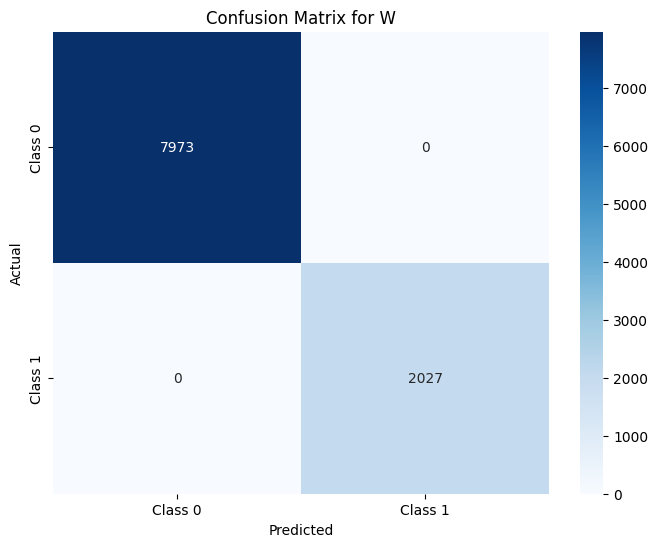

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_w_target, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for W')
plt.show()

In [ ]:
q_W_given_ZA = get_probabilities(model_q_W, Z_target, A_target)
q_W_given_ZA

array([[[0.98553003, 0.01446997],
        [0.98763835, 0.01236165],
        [0.9855957 , 0.0144043 ]],

       [[0.0351435 , 0.9648565 ],
        [0.04097614, 0.95902386],
        [0.03530034, 0.96469966]]])

In [ ]:
print("Step 3 done")

Step 3 done


In [ ]:
# Now we extract q_W_given_ZA for specific a
q_W_given_ZA_specific_a = q_W_given_ZA[:, specific_a_index, :]
q_W_given_ZA_specific_a

array([[0.98553003, 0.01446997],
       [0.0351435 , 0.9648565 ]])

In [ ]:
p_W_given_epsilon

array([[0.08219042, 0.86062597],
       [0.79450438, 0.08172563]])

In [ ]:
# TODO: CHECK IF TRANSPOSES NEEDED ETC
q_epsilon_given_Z_and_A, _, _, _ = np.linalg.lstsq(p_W_given_epsilon, q_W_given_ZA_specific_a, rcond=None) 

In [ ]:
q_epsilon_given_Z_and_A

array([[-0.07428898,  1.22471464],
       [ 1.15222629, -0.10014785]])

In [ ]:
print("Step 4 done")

Step 4 done


In [ ]:
A_target

[tensor([1., 0., 0.]),
 tensor([0., 1., 0.]),
 tensor([1., 1., 0.]),
 tensor([1., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([1., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 1.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 0., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 0., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([1., 1., 0.]),
 tensor([0., 1., 1.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 1.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 0., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 1.]),
 tensor([1., 0., 0.]),
 tensor([0., 1., 0.]),
 tensor([0.

In [ ]:
Z_target

[tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([-1,  1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([-1,  1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([-1,  1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([-1,  1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([-1,  1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1, -1]),
 tensor([ 1,

In [ ]:
# Convert the list of tensors to a list of binary labels
binary_labels_target_Z = [tensor_to_binary(t) for t in Z_target]

# Convert to numpy array (optional)
binary_labels_target_array_Z = np.array(binary_labels_target_Z)

In [ ]:
binary_labels_target_array_Z

array([1, 1, 1, ..., 1, 1, 0])

In [ ]:
# Train model to estimate q(Z|a)
model_q_Z = SklearnLogisticRegression(max_iter=1000)
model_q_Z.fit(A_target, binary_labels_target_array_Z)

LogisticRegression(max_iter=1000)

In [ ]:
Z_train_pred_target = model_q_Z.predict(A_target)
print("Z_target_pred",Z_train_pred_target)

Z_train_true_target = Z_target
accuracy_W_train_target = np.mean(Z_train_pred_target == binary_labels_target_array_Z)
print(f"Accuracy of model_W on training set: {accuracy_W_train_target:.4f}")

Z_target_pred [1 1 1 ... 1 1 1]
Accuracy of model_W on training set: 0.7973


In [ ]:
cm_z_target = confusion_matrix(binary_labels_target_array_Z, model_q_Z.predict(A_target))
print("Classification Report for Z:")
print(classification_report(binary_labels_target_array_Z, model_q_Z.predict(A_target)))

Classification Report for Z:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2027
           1       0.80      1.00      0.89      7973

    accuracy                           0.80     10000
   macro avg       0.40      0.50      0.44     10000
weighted avg       0.64      0.80      0.71     10000



/Users/rickcollins64/opt/anaconda3/envs/MV00/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rickcollins64/opt/anaconda3/envs/MV00/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rickcollins64/opt/anaconda3/envs/MV00/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

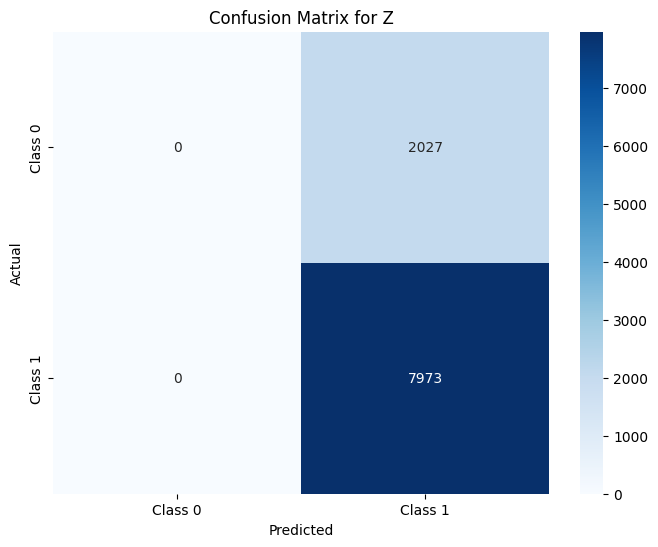

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_z_target, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Z')
plt.show()

In [ ]:
print("Step 5 done")

Step 5 done


In [ ]:
p_Y_given_epsilon

array([[0.80536971, 0.06984851],
       [0.80017231, 0.07552989]])

In [ ]:
q_epsilon_given_Z_and_A

array([[-0.07428898,  1.22471464],
       [ 1.15222629, -0.10014785]])

In [ ]:
q_Z_given_A

NameError: name 'q_Z_given_A' is not defined

In [ ]:
q_Y_given_A = p_Y_given_epsilon@(q_epsilon_given_Z_and_A@q_Z_given_A_reshaped)